<a href="https://colab.research.google.com/github/BassoTara/SeeFoodCNN/blob/master/GiulioBassetti_SeeFoodCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install keras
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

#SeeFood - Train a food CNN classifier

![Not hot Dog Demo](https://www.semantics3.com/blog/content/images/downloaded_images/hot-dog-and-a-not-hot-dog-the-distinction-matters-code-included-8550067fb16/1-VrpXE1hE4rO1roK0laOd7g.png)


##Introduction
In this lab you have learned how to create a deep neural network from scratch and how to fine tune a network on a different dataset. In particular you used convolutional neural networks to classify images.

In this exercise you need to replicate the infamous application made by Jian Yang. The system should differentiate between images of hot dog and not hot dogs...

We provided you  a dataset of hot dogs and not hot dogs.

Solve the following two exercises and write a brief report of max 2 pages on your approach reporting results and consideration on the most relevant experiments.




## Exercise 1

Train a deep CNN from scratch use as many filters and layers you believe are needed. Report train and validation accuracy per epoch. Employ regularization and augmentation to improve results.

### Choosing a proper model
For the first task of choosing a proper model, I want to try different models and compare them using a k-fold cross validation for each of them. The model which gives the best results will then be trained on the whole training set and used for the rest of the exercises.

#### Downloading and preparing data
Here I want to mount Google Drive and select the folders containing our dataset. I will comment lines of code I don't want to run every time.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My Drive

/content/drive/My Drive


In [0]:
# !unzip dataset/seefood.zip

In [0]:
!ls

'Colab Notebooks'  'Modulo_D&D_eng.gform'     seefood_with_validation
 dataset	    rete-minchia-vero.ipynb   seefood_with_validation.zip
'Laboratorio CNN'   seefood		      seefood.zip
 model.png	    seefood_kfold


In [0]:
# set general directories... will be used later.
train_dir = 'seefood_kfold/train'
test_dir = 'seefood_kfold/test'

IMAGE_WIDTH = IMAGE_HEIGHT = 150
NUM_TRAIN_IMAGES = 498
NUM_TRAIN_IMAGES_KFOLD = 448
NUM_TEST_IMAGES = 500
NUM_VAL_IMAGES = 50

 #### Building a model

In [0]:
from keras import models
from keras import layers
import numpy as np

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen_rescale = ImageDataGenerator(
    rescale=1./255)

train_datagen_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    )

test_datagen = ImageDataGenerator(
    rescale=1./255,
    )

In [0]:
def create_cv_train_generator(train_datagen, fold):
    
    train_dir_fold = train_dir + '_' + str(fold)
    
    train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            train_dir_fold,
            # All images will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')  
     
    return train_generator

  
def create_cv_val_generator(test_datagen, fold):
    
    val_dir_fold = 'seefood_kfold/val_' + str(fold)
    
    val_generator = test_datagen.flow_from_directory(
            # This is the target directory
            val_dir_fold,
            # All images will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')
  
    return val_generator

In [0]:
def cv_fit_model(build_model_function, train_datagen, test_datagen):

  cvscores = []

  for fold in range(10):
    print('Fold:', fold)
    
    model = build_model_function()
    
    train_generator = create_cv_train_generator(train_datagen, fold)
    validation_generator = create_cv_val_generator(test_datagen, fold)
    
    history = model.fit_generator(train_generator,
                        epochs = EPOCHS, 
                        steps_per_epoch = NUM_TRAIN_IMAGES // BATCH_SIZE, 
                        validation_data = validation_generator, 
                        validation_steps = NUM_VAL_IMAGES // BATCH_SIZE,
                        verbose = VERBOSE)
    
    cvscores.append(history.history['val_acc'][-1] * 100)
    
  return model, cvscores

In [0]:
EPOCHS = 20
VERBOSE = 1
BATCH_SIZE = 20

##### Model 1, No Augmentation

In [0]:
def build_model_1():
  model = models.Sequential()
  model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  
  model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  
  model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  
  model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))


  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
model, cvscores = cv_fit_model(build_model_1, train_datagen_rescale, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 5s 197ms/step - loss: 0.7077 - acc: 0.4785 - val_loss: 0.6932 - val_acc: 0.4750
Epoch 2/20
24/24 [==============================] - 3s 135ms/step - loss: 0.6941 - acc: 0.4958 - val_loss: 0.6917 - val_acc: 0.6333
Epoch 3/20
24/24 [==============================] - 3s 137ms/step - loss: 0.6926 - acc: 0.4997 - val_loss: 0.7147 - val_acc: 0.3333
Epoch 4/20
24/24 [==============================] - 3s 140ms/step - loss: 0.6845 - acc: 0.5456 - val_loss: 0.6575 - val_acc: 0.5500
Epoch 5/20
24/24 [==============================] - 3s 136ms/step - loss: 0.6552 - acc: 0.5813 - val_loss: 0.9841 - val_acc: 0.5667
Epoch 6/20
24/24 [==============================] - 3s 139ms/step - loss: 0.6694 - acc: 0.6043 - val_loss: 0.6938 - val_acc: 0.6333
Epoch 7/20
24/24 [==============================] - 3s 141ms/step - loss: 0.6365 - acc: 0.6436 - val_loss: 0.6598 - val

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 15, 15, 128)       147584    
__________

#### Testing different models without data augmentation

 ##### Model 2, No Augmentation

In [0]:
def build_model_2():
  model = models.Sequential()
  model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Dropout(0.5))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
model, cvscores = cv_fit_model(build_model_2, train_datagen_rescale, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 6s 242ms/step - loss: 1.3747 - acc: 0.5030 - val_loss: 0.6929 - val_acc: 0.5250
Epoch 2/20
24/24 [==============================] - 3s 134ms/step - loss: 0.6923 - acc: 0.5000 - val_loss: 0.6943 - val_acc: 0.4333
Epoch 3/20
24/24 [==============================] - 4s 148ms/step - loss: 0.6933 - acc: 0.4940 - val_loss: 0.6925 - val_acc: 0.5333
Epoch 4/20
24/24 [==============================] - 4s 153ms/step - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6929 - val_acc: 0.5250
Epoch 5/20
24/24 [==============================] - 4s 149ms/step - loss: 0.6931 - acc: 0.4896 - val_loss: 0.6936 - val_acc: 0.4333
Epoch 6/20
24/24 [==============================] - 4s 149ms/step - loss: 0.6971 - acc: 0.5265 - val_loss: 0.6925 - val_acc: 0.5333
Epoch 7/20
24/24 [==============================] - 4s 152ms/step - loss: 0.6933 - acc: 0.5176 - val_loss: 0.6926 - val

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 34, 34, 128)       73856     
__________

##### Model 3, No Augmentation

In [0]:
def build_model_3():
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size = (2, 2)))
  model.add(layers.Dropout(0.5))


  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
model, cvscores = cv_fit_model(build_model_3, train_datagen_rescale, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 8s 332ms/step - loss: 6.5498 - acc: 0.5516 - val_loss: 7.0347 - val_acc: 0.5250
Epoch 2/20
24/24 [==============================] - 3s 122ms/step - loss: 5.4431 - acc: 0.5250 - val_loss: 2.7667 - val_acc: 0.5333
Epoch 3/20
24/24 [==============================] - 3s 143ms/step - loss: 3.7205 - acc: 0.5459 - val_loss: 1.1385 - val_acc: 0.7000
Epoch 4/20
24/24 [==============================] - 4s 146ms/step - loss: 1.8165 - acc: 0.5992 - val_loss: 2.0277 - val_acc: 0.4750
Epoch 5/20
24/24 [==============================] - 3s 144ms/step - loss: 1.2726 - acc: 0.6847 - val_loss: 1.7457 - val_acc: 0.4667
Epoch 6/20
24/24 [==============================] - 3s 145ms/step - loss: 1.2144 - acc: 0.6230 - val_loss: 0.9907 - val_acc: 0.6667
Epoch 7/20
24/24 [==============================] - 4s 148ms/step - loss: 1.0457 - acc: 0.6728 - val_loss: 1.0448 - val

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_37 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_38 (Batc (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 36, 36, 64)        0         
__________

##### Model 4, No Augmentation

In [0]:
def build_model_4():
  
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(32, (3, 3)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(64, (3, 3)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(64))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1))
  model.add(layers.Activation('sigmoid'))
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
model, cvscores = cv_fit_model(build_model_4, train_datagen_rescale, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 11s 441ms/step - loss: 0.6992 - acc: 0.5086 - val_loss: 0.6944 - val_acc: 0.4750
Epoch 2/20
24/24 [==============================] - 3s 107ms/step - loss: 0.6861 - acc: 0.5832 - val_loss: 0.6749 - val_acc: 0.5667
Epoch 3/20
24/24 [==============================] - 3s 135ms/step - loss: 0.6594 - acc: 0.6219 - val_loss: 0.6880 - val_acc: 0.6000
Epoch 4/20
24/24 [==============================] - 3s 137ms/step - loss: 0.6543 - acc: 0.6436 - val_loss: 0.6859 - val_acc: 0.5500
Epoch 5/20
24/24 [==============================] - 3s 138ms/step - loss: 0.6430 - acc: 0.6418 - val_loss: 0.6848 - val_acc: 0.5333
Epoch 6/20
24/24 [==============================] - 3s 137ms/step - loss: 0.6266 - acc: 0.6592 - val_loss: 0.7051 - val_acc: 0.5000
Epoch 7/20
24/24 [==============================] - 3s 139ms/step - loss: 0.5678 - acc: 0.7291 - val_loss: 0.8137 - va

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
activation_46 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_47 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_163 (MaxPoolin (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 34, 34, 64)        18496     
__________

##### Model 5, No Augmentation

In [0]:
def build_model_5():
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), activation = 'relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.MaxPooling2D(pool_size=(3, 3)))

  model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size=(3, 3)))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation ='sigmoid'))
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
model, cvscores = cv_fit_model(build_model_4, train_datagen_rescale, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 12s 520ms/step - loss: 0.7116 - acc: 0.5352 - val_loss: 0.7051 - val_acc: 0.4500
Epoch 2/20
24/24 [==============================] - 2s 101ms/step - loss: 0.6905 - acc: 0.5531 - val_loss: 0.6817 - val_acc: 0.5333
Epoch 3/20
24/24 [==============================] - 3s 138ms/step - loss: 0.6690 - acc: 0.5772 - val_loss: 0.6671 - val_acc: 0.5667
Epoch 4/20
24/24 [==============================] - 3s 141ms/step - loss: 0.6374 - acc: 0.6585 - val_loss: 0.6788 - val_acc: 0.6500
Epoch 5/20
24/24 [==============================] - 3s 138ms/step - loss: 0.6090 - acc: 0.6588 - val_loss: 0.7927 - val_acc: 0.5000
Epoch 6/20
24/24 [==============================] - 3s 138ms/step - loss: 0.5555 - acc: 0.7310 - val_loss: 0.7511 - val_acc: 0.6333
Epoch 7/20
24/24 [==============================] - 3s 141ms/step - loss: 0.4929 - acc: 0.7634 - val_loss: 0.8708 - va

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
activation_96 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_97 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 34, 34, 64)        18496     
__________

In [0]:
IMAGE_WIDTH = IMAGE_HEIGHT = 150

model = build_model_5()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                921664    
__________

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes = True, to_file='model.png')

#### Testing different models with data augmentation
Since I'm using data augmentation, I also want to increase the number of epochs

In [0]:
EPOCHS = 50
VERBOSE = 1
BATCH_SIZE = 20

##### Model 1, Augmentation

In [0]:
model, cvscores = cv_fit_model(build_model_1, train_datagen_augmentation, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/50
24/24 [==============================] - 137s 6s/step - loss: 0.7098 - acc: 0.5206 - val_loss: 0.6880 - val_acc: 0.5500
Epoch 2/50
24/24 [==============================] - 6s 231ms/step - loss: 0.6894 - acc: 0.5023 - val_loss: 0.7197 - val_acc: 0.5000
Epoch 3/50
24/24 [==============================] - 6s 237ms/step - loss: 0.6753 - acc: 0.5971 - val_loss: 0.6619 - val_acc: 0.5667
Epoch 4/50
24/24 [==============================] - 6s 240ms/step - loss: 0.6580 - acc: 0.6200 - val_loss: 0.7051 - val_acc: 0.5000
Epoch 5/50
24/24 [==============================] - 6s 238ms/step - loss: 0.6799 - acc: 0.5646 - val_loss: 0.6759 - val_acc: 0.6333
Epoch 6/50
24/24 [==============================] - 6s 237ms/step - loss: 0.6730 - acc: 0.5679 - val_loss: 0.7466 - val_acc: 0.6667
Epoch 7/50
24/24 [==============================] - 6s 241ms/step - loss: 0.6727 - acc: 0.6052 - val_loss: 0.7068 - val_

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 15, 15, 128)       147584    
__________

##### Model 2, Augmentation

In [0]:
model, cvscores = cv_fit_model(build_model_2, train_datagen_augmentation, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/50
24/24 [==============================] - 8s 322ms/step - loss: 1.4632 - acc: 0.5199 - val_loss: 0.6934 - val_acc: 0.4500
Epoch 2/50
24/24 [==============================] - 6s 237ms/step - loss: 0.6933 - acc: 0.4797 - val_loss: 0.6929 - val_acc: 0.6333
Epoch 3/50
24/24 [==============================] - 6s 246ms/step - loss: 0.6932 - acc: 0.5021 - val_loss: 0.6929 - val_acc: 0.5667
Epoch 4/50
24/24 [==============================] - 6s 247ms/step - loss: 0.6932 - acc: 0.4979 - val_loss: 0.6930 - val_acc: 0.5250
Epoch 5/50
24/24 [==============================] - 6s 246ms/step - loss: 0.6933 - acc: 0.4884 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/50
24/24 [==============================] - 6s 245ms/step - loss: 0.6932 - acc: 0.4681 - val_loss: 0.6933 - val_acc: 0.4667
Epoch 7/50
24/24 [==============================] - 6s 246ms/step - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6934 - val

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 34, 34, 128)       73856     
__________

##### Model 3, Augmentation

In [0]:
model, cvscores = cv_fit_model(build_model_3, train_datagen_augmentation, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/50
24/24 [==============================] - 189s 8s/step - loss: 2.5502 - acc: 0.5396 - val_loss: 3.2643 - val_acc: 0.5250
Epoch 2/50
24/24 [==============================] - 6s 242ms/step - loss: 0.8871 - acc: 0.5396 - val_loss: 2.5516 - val_acc: 0.5667
Epoch 3/50
24/24 [==============================] - 6s 240ms/step - loss: 0.6729 - acc: 0.5820 - val_loss: 3.9400 - val_acc: 0.3333
Epoch 4/50
24/24 [==============================] - 6s 248ms/step - loss: 0.6745 - acc: 0.5813 - val_loss: 3.3750 - val_acc: 0.5250
Epoch 5/50
24/24 [==============================] - 6s 245ms/step - loss: 0.6613 - acc: 0.6520 - val_loss: 4.4665 - val_acc: 0.5000
Epoch 6/50
24/24 [==============================] - 6s 242ms/step - loss: 0.6483 - acc: 0.6469 - val_loss: 3.5430 - val_acc: 0.5333
Epoch 7/50
24/24 [==============================] - 6s 247ms/step - loss: 0.6557 - acc: 0.6323 - val_loss: 3.6271 - val_

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_37 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_38 (Batc (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 36, 36, 64)        0         
__________

##### Model 4, Augmentation

In [0]:
model, cvscores = cv_fit_model(build_model_4, train_datagen_augmentation, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/50
24/24 [==============================] - 8s 343ms/step - loss: 0.7076 - acc: 0.5063 - val_loss: 0.6929 - val_acc: 0.4750
Epoch 2/50
24/24 [==============================] - 5s 224ms/step - loss: 0.6947 - acc: 0.4840 - val_loss: 0.7051 - val_acc: 0.4000
Epoch 3/50
24/24 [==============================] - 6s 234ms/step - loss: 0.6932 - acc: 0.5394 - val_loss: 0.6910 - val_acc: 0.5333
Epoch 4/50
24/24 [==============================] - 6s 236ms/step - loss: 0.6916 - acc: 0.5411 - val_loss: 0.6934 - val_acc: 0.4500
Epoch 5/50
24/24 [==============================] - 6s 236ms/step - loss: 0.6877 - acc: 0.5614 - val_loss: 0.7144 - val_acc: 0.3333
Epoch 6/50
24/24 [==============================] - 6s 234ms/step - loss: 0.6868 - acc: 0.5774 - val_loss: 0.6637 - val_acc: 0.6667
Epoch 7/50
24/24 [==============================] - 6s 236ms/step - loss: 0.6691 - acc: 0.6061 - val_loss: 0.7035 - val

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_46 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_47 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 34, 34, 64)        18496     
__________

##### Model 5, Augmentation

In [0]:
model, cvscores = cv_fit_model(build_model_5, train_datagen_augmentation, test_datagen)

Fold: 0
Found 448 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/50
24/24 [==============================] - 142s 6s/step - loss: 0.7277 - acc: 0.4877 - val_loss: 0.6911 - val_acc: 0.5500
Epoch 2/50
24/24 [==============================] - 5s 224ms/step - loss: 0.6896 - acc: 0.5259 - val_loss: 0.6914 - val_acc: 0.5667
Epoch 3/50
24/24 [==============================] - 5s 228ms/step - loss: 0.6925 - acc: 0.5271 - val_loss: 0.6895 - val_acc: 0.5333
Epoch 4/50
24/24 [==============================] - 5s 228ms/step - loss: 0.6772 - acc: 0.5804 - val_loss: 0.6848 - val_acc: 0.6750
Epoch 5/50
24/24 [==============================] - 5s 223ms/step - loss: 0.6702 - acc: 0.6038 - val_loss: 0.7099 - val_acc: 0.4333
Epoch 6/50
24/24 [==============================] - 5s 226ms/step - loss: 0.6710 - acc: 0.6084 - val_loss: 0.6936 - val_acc: 0.6667
Epoch 7/50
24/24 [==============================] - 6s 229ms/step - loss: 0.6801 - acc: 0.6013 - val_loss: 0.7127 - val_

In [0]:
model.summary()
print('Score for this model:')
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
dropout_21 (Dropout)         (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 14400)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                921664    
__________

### Testing the chosen model on the test set, training it on the whole training set without validation

In [0]:
EPOCHS = 150
BATCH_SIZE = 20
VERBOSE = 1

In [0]:
def create_train_generator(train_datagen):
    
    train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            train_dir,
            # All images will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

    return train_generator

In [0]:
def fit_model(build_model_function, train_datagen):
    
    model = build_model_function()
 
    train_generator = create_train_generator(train_datagen)

    history = model.fit_generator(train_generator,
                      epochs = EPOCHS, 
                      steps_per_epoch = NUM_TRAIN_IMAGES // BATCH_SIZE, 
                      verbose = VERBOSE)
    
    return model, history

In [0]:
# model = build_model_1()
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [0]:
model, history = fit_model(build_model_5, train_datagen_augmentation)

NameError: ignored

In [0]:
model.summary()

test_generator = test_datagen.flow_from_directory(
            # This is the target directory
            test_dir,
            # All images will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=NUM_TEST_IMAGES // BATCH_SIZE)
print('test acc:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                921664    
__________


##Exercise 2

Fine-tune a network of your choice. Report train and validation accuracy per epoch. Employ regularization and augmentation to improve results.
which approach works better?


In [0]:
EPOCHS = 70
BATCH_SIZE = 20
VERBOSE = 1

In [0]:
def build_finetuned_model(conv_base):
  
  model = models.Sequential()
  model.add(conv_base)
  
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  
  conv_base.trainable = False
  
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model

### VGG16

In [0]:
from keras.applications import VGG16

def build_finetuned_model_vgg16():
  
  conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
  
  model = build_finetuned_model(conv_base)
  
  return model

In [0]:
model, history = fit_model(build_finetuned_model_vgg16, train_datagen_augmentation)

58892288/58889256 [==============================] - 5s 0us/step
Found 498 images belonging to 2 classes.
Epoch 1/100
24/24 [==============================] - 15s 622ms/step - loss: 1.0130 - acc: 0.5750
Epoch 2/100
24/24 [==============================] - 7s 281ms/step - loss: 0.5138 - acc: 0.7370
Epoch 3/100
24/24 [==============================] - 6s 266ms/step - loss: 0.5147 - acc: 0.7680
Epoch 4/100
24/24 [==============================] - 6s 264ms/step - loss: 0.5003 - acc: 0.7572
Epoch 5/100
24/24 [==============================] - 6s 265ms/step - loss: 0.4141 - acc: 0.8060
Epoch 6/100
24/24 [==============================] - 6s 266ms/step - loss: 0.4318 - acc: 0.7970
Epoch 7/100
24/24 [==============================] - 6s 265ms/step - loss: 0.4323 - acc: 0.7993
Epoch 8/100
24/24 [==============================] - 6s 265ms/step - loss: 0.4682 - acc: 0.7822
Epoch 9/100
24/24 [==============================] - 6s 267ms/step - loss: 0.3947 - acc: 0.8204
Epoch 10/100
24/24 [=========

In [0]:
model.layers[0].trainable = True
model.layers[0].summary()

for i, layer in enumerate(model.layers[0].layers):
  if i < 15:
    layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
train_gen = create_train_generator(train_datagen_augmentation)

test_generator = test_datagen.flow_from_directory(
            # This is the target directory
            test_dir,
            # All images will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

history = model.fit_generator(train_gen,
                  epochs = EPOCHS, 
                  steps_per_epoch = NUM_TRAIN_IMAGES // BATCH_SIZE,
                  validation_data = test_generator,
                  validation_steps = NUM_TEST_IMAGES // BATCH_SIZE,
                  verbose = VERBOSE)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/100
24/24 [==============================] - 20s 824ms/step - loss: 0.4719 - acc: 0.8208 - val_loss: 0.5785 - val_acc: 0.7600
Epoch 2/100
24/24 [==============================] - 8s 342ms/step - loss: 0.3129 - acc: 0.8889 - val_loss: 0.4851 - val_acc: 0.8160
Epoch 3/100
24/24 [==============================] - 9s 367ms/step - loss: 0.3166 - acc: 0.8850 - val_loss: 0.4556 - val_acc: 0.8240
Epoch 4/100
24/24 [==============================] - 9s 367ms/step - loss: 0.2262 - acc: 0.9058 - val_loss: 0.5203 - val_acc: 0.8300
Epoch 5/100
24/24 [==============================] - 9s 365ms/step - loss: 0.1929 - acc: 0.9187 - val_loss: 0.6114 - val_acc: 0.8060
Epoch 6/100
24/24 [==============================] - 9s 368ms/step - loss: 0.2561 - acc: 0.9018 - val_loss: 0.6330 - val_acc: 0.8020
Epoch 7/100
24/24 [==============================] - 9s 365ms/step - loss: 0.1485 - acc: 0.9479 - val_loss: 0.6288 - va

In [0]:
model.summary()

test_loss, test_acc = model.evaluate_generator(test_generator, steps=NUM_TEST_IMAGES // BATCH_SIZE)
print('test acc:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 11,274,753
Non-trainable params: 7,635,264
_________________________________________________________________
test acc: 0.847999997138977


### Inception

In [0]:
from keras.applications import InceptionV3

def build_finetuned_model_inception_v3():
  
  conv_base = InceptionV3(weights='imagenet',
                    include_top=False,
                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
  
  model = build_finetuned_model(conv_base)
  
  return model

In [0]:
model, history = fit_model(build_finetuned_model_inception_v3, train_datagen_augmentation)

Found 498 images belonging to 2 classes.
Epoch 1/100
24/24 [==============================] - 19s 783ms/step - loss: 4.9527 - acc: 0.5313
Epoch 2/100
24/24 [==============================] - 6s 253ms/step - loss: 1.1993 - acc: 0.5683
Epoch 3/100
24/24 [==============================] - 6s 255ms/step - loss: 0.5624 - acc: 0.7558
Epoch 4/100
24/24 [==============================] - 6s 257ms/step - loss: 0.4806 - acc: 0.7741
Epoch 5/100
24/24 [==============================] - 6s 256ms/step - loss: 0.4994 - acc: 0.7699
Epoch 6/100
24/24 [==============================] - 6s 256ms/step - loss: 0.5854 - acc: 0.7303
Epoch 7/100
24/24 [==============================] - 6s 257ms/step - loss: 0.5955 - acc: 0.7407
Epoch 8/100
24/24 [==============================] - 6s 255ms/step - loss: 0.5252 - acc: 0.7711
Epoch 9/100
24/24 [==============================] - 6s 258ms/step - loss: 0.4972 - acc: 0.7507
Epoch 10/100
24/24 [==============================] - 6s 258ms/step - loss: 0.5091 - acc: 0.76

In [0]:
model.layers[0].trainable = True
model.layers[0].summary()

for i, layer in enumerate(model.layers[0].layers):
  if i < 276:
    layer.trainable = False

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_193 (BatchN (None, 74, 74, 32)   96          conv2d_193[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 74, 74, 32)   0           batch_normalization_193[0][0]    
__________________________________________________________________________________________________
conv2d_194

In [0]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
train_gen = create_train_generator(train_datagen_augmentation)

test_generator = test_datagen.flow_from_directory(
            # This is the target directory
            test_dir,
            # All images will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

history = model.fit_generator(train_gen,
                  epochs = EPOCHS, 
                  steps_per_epoch = NUM_TRAIN_IMAGES // BATCH_SIZE,
                  validation_data = test_generator,
                  validation_steps = NUM_TEST_IMAGES // BATCH_SIZE,
                  verbose = VERBOSE)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/100
24/24 [==============================] - 30s 1s/step - loss: 0.4009 - acc: 0.8312 - val_loss: 0.5000 - val_acc: 0.8060
Epoch 2/100
24/24 [==============================] - 8s 347ms/step - loss: 0.3131 - acc: 0.8660 - val_loss: 0.5053 - val_acc: 0.8000
Epoch 3/100
24/24 [==============================] - 9s 379ms/step - loss: 0.3344 - acc: 0.8572 - val_loss: 0.4679 - val_acc: 0.8280
Epoch 4/100
24/24 [==============================] - 9s 378ms/step - loss: 0.2974 - acc: 0.8845 - val_loss: 0.5131 - val_acc: 0.7980
Epoch 5/100
24/24 [==============================] - 9s 376ms/step - loss: 0.3095 - acc: 0.8643 - val_loss: 0.4398 - val_acc: 0.8180
Epoch 6/100
24/24 [==============================] - 9s 375ms/step - loss: 0.2350 - acc: 0.9018 - val_loss: 0.4666 - val_acc: 0.8240
Epoch 7/100
24/24 [==============================] - 9s 379ms/step - loss: 0.2515 - acc: 0.8870 - val_loss: 0.5856 - val_a

In [0]:
model.summary()

test_loss, test_acc = model.evaluate_generator(test_generator, steps=NUM_TEST_IMAGES // BATCH_SIZE)
print('test acc:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 31,240,993
Trainable params: 15,511,745
Non-trainable params: 15,729,248
_________________________________________________________________
test acc: 0.8239999985694886


### Xception

In [0]:
IMAGE_WIDTH = IMAGE_HEIGHT = 256
EPOCHS = 30

In [0]:
from keras.applications import Xception

def build_finetuned_model_xception():
  
  conv_base = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
  
  model = build_finetuned_model(conv_base)
  
  return model

In [0]:
model, history = fit_model(build_finetuned_model_xception, train_datagen_augmentation)

83689472/83683744 [==============================] - 4s 0us/step
Found 498 images belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 200s 8s/step - loss: 6.1786 - acc: 0.5771
Epoch 2/30
24/24 [==============================] - 20s 821ms/step - loss: 4.5560 - acc: 0.6961
Epoch 3/30
24/24 [==============================] - 13s 531ms/step - loss: 5.1394 - acc: 0.6627
Epoch 4/30
24/24 [==============================] - 13s 534ms/step - loss: 5.0831 - acc: 0.6611
Epoch 5/30
24/24 [==============================] - 13s 538ms/step - loss: 3.1057 - acc: 0.7970
Epoch 6/30
24/24 [==============================] - 13s 530ms/step - loss: 3.2894 - acc: 0.7771
Epoch 7/30
24/24 [==============================] - 13s 532ms/step - loss: 4.1758 - acc: 0.7285
Epoch 8/30
24/24 [==============================] - 13s 531ms/step - loss: 4.4938 - acc: 0.7157
Epoch 9/30
24/24 [==============================] - 13s 533ms/step - loss: 4.2299 - acc: 0.7301
Epoch 10/30
24/24 [=============

In [0]:
model.layers[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [0]:
model.layers[0].trainable = True
model.layers[0].summary()

for i, layer in enumerate(model.layers[0].layers):
  if i < 116:
    layer.trainable = False

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [0]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
train_gen = create_train_generator(train_datagen_augmentation)

test_generator = test_datagen.flow_from_directory(
            # This is the target directory
            test_dir,
            # All images will be resized to IMAGE_WIDTH x IMAGE_HEIGHT
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

history = model.fit_generator(train_gen,
                  epochs = EPOCHS, 
                  steps_per_epoch = NUM_TRAIN_IMAGES // BATCH_SIZE,
                  validation_data = test_generator,
                  validation_steps = NUM_TEST_IMAGES // BATCH_SIZE,
                  verbose = VERBOSE)

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 173s 7s/step - loss: 2.5943 - acc: 0.8333 - val_loss: 2.3902 - val_acc: 0.8440
Epoch 2/30
24/24 [==============================] - 16s 687ms/step - loss: 2.7443 - acc: 0.8241 - val_loss: 2.4555 - val_acc: 0.8440
Epoch 3/30
24/24 [==============================] - 17s 711ms/step - loss: 2.8482 - acc: 0.8185 - val_loss: 2.4266 - val_acc: 0.8440
Epoch 4/30
24/24 [==============================] - 17s 714ms/step - loss: 2.5822 - acc: 0.8370 - val_loss: 2.4507 - val_acc: 0.8460
Epoch 5/30
24/24 [==============================] - 17s 719ms/step - loss: 3.1021 - acc: 0.8058 - val_loss: 2.4623 - val_acc: 0.8460
Epoch 6/30
24/24 [==============================] - 17s 718ms/step - loss: 2.7877 - acc: 0.8183 - val_loss: 2.4415 - val_acc: 0.8460
Epoch 7/30
24/24 [==============================] - 17s 715ms/step - loss: 2.6570 - acc: 0.8280 - val_loss: 2.3678 - val_a

In [0]:
model.summary()

test_loss, test_acc = model.evaluate_generator(test_generator, steps=NUM_TEST_IMAGES // BATCH_SIZE)
print('test acc:', test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 87,971,369
Trainable params: 73,898,273
Non-trainable params: 14,073,096
_________________________________________________________________
test acc: 0.8600000047683716


##Exercise 3

Test it in the wild!
First how long does it take to your system to analyze a single image? Can this be used in a real-time application? In case not what can you do to make it faster?

Take some pictures of food with your phone (download hot dog images if you do not have them available) and check if you can See Food for real!



In [0]:
from google.colab import files
uploaded = files.upload()

Saving 44496352_1143414115805589_8420566788114571234_n.jpg to 44496352_1143414115805589_8420566788114571234_n.jpg
Saving 46052625_371752623391926_2155709565703256127_n.jpg to 46052625_371752623391926_2155709565703256127_n.jpg
Saving 46930150_352554925558302_8704397821281725173_n.jpg to 46930150_352554925558302_8704397821281725173_n.jpg
Saving 47002171_147518786232001_6692911059805056921_n.jpg to 47002171_147518786232001_6692911059805056921_n.jpg
Saving 47293347_2189433377986380_4346293506225166643_n.jpg to 47293347_2189433377986380_4346293506225166643_n.jpg
Saving 47322017_580169155758423_533763657780166656_n.jpg to 47322017_580169155758423_533763657780166656_n.jpg
Saving 47691062_300919630421974_3295312093969387733_n.jpg to 47691062_300919630421974_3295312093969387733_n.jpg
Saving 47694628_2005928142828553_4178528170234420452_n.jpg to 47694628_2005928142828553_4178528170234420452_n.jpg
Saving instahotdog0.jpg to instahotdog0 (1).jpg
Saving instahotdog1.jpg to instahotdog1.jpg


In [0]:
test_generator.class_indices

{'hot_dog': 0, 'not_hot_dog': 1}

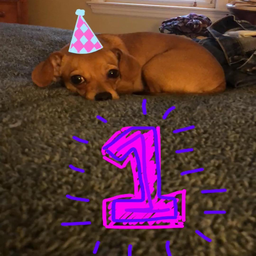

Not Hot Dog
Seconds: 0.19161462783813477


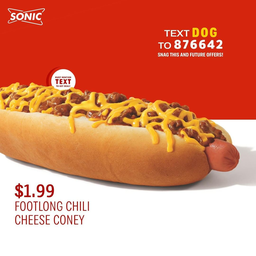

Hot Dog
Seconds: 0.16143560409545898


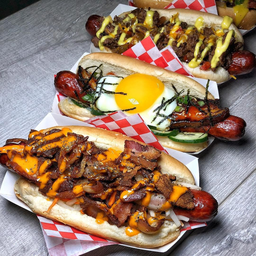

Hot Dog
Seconds: 0.18407869338989258


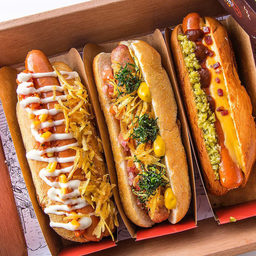

Hot Dog
Seconds: 0.17848539352416992


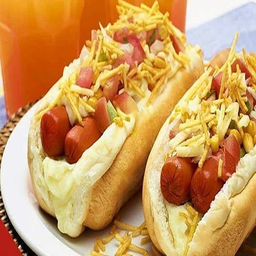

Hot Dog
Seconds: 0.14766383171081543


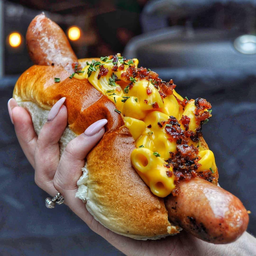

Hot Dog
Seconds: 0.1740283966064453


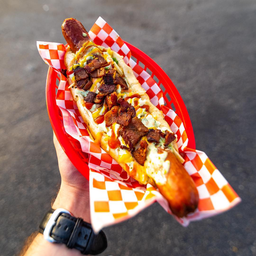

Hot Dog
Seconds: 0.17841458320617676


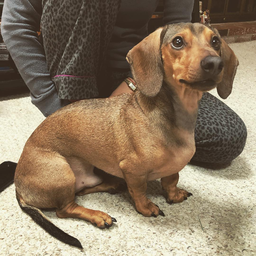

Not Hot Dog
Seconds: 0.19570183753967285


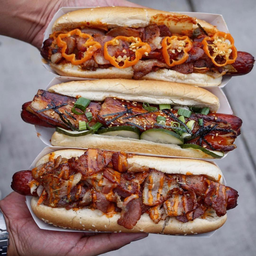

Hot Dog
Seconds: 0.18141651153564453


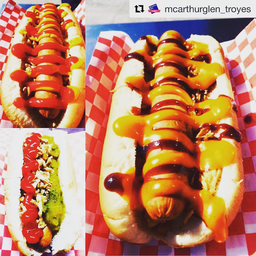

Hot Dog
Seconds: 0.1712186336517334


In [0]:
from PIL import Image
import time

for key in uploaded:
  start_time = time.time()
  
  img = Image.open(key)
  
  img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
  display(img)
  
  img_tensor = np.array(img.getdata(),np.float32).reshape(img.size[0], img.size[1], 3)
  img_tensor = img_tensor/255
  
  out = model.predict(np.expand_dims(img_tensor, axis=0))
  result = int(np.round(out))
  if(result):
    print("Not Hot Dog")
  else:
    print("Hot Dog")
    
  print("Seconds:", time.time()-start_time)